# Predicting housing prices using linear regression

We are using linear regression in order to predict housing prices from an example Kaggle dataset.

This is a part of the [ML Zoomcamp](https://github.com/DataTalksClub/machine-learning-zoomcamp/), a guided set of tutorials on teaching machine learning.

Source: https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/02-regression/homework.md


In [1]:
# we grab the data 
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

Let's get our data loaded as well as import any necessary packages


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [3]:
df = pd.read_csv("housing.csv")

Just taking a peek at the data that we have:


In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory data

Before we start doing any machine learning, we should take a look at the data that we have, so that we can get a general sense of what we're working with. The purpose of this exploration is twofold:

1. Check the relationships that the features have with each other and with the output variable. Doing so will let us see if any of the features are correlated with each other as well as get an idea for how the features should correlate with the output variable.
2. Determine which features to use in our model.


We want to predict the `median_house_value` column, so let's pull that from our dataset and just see how it looks


<Axes: xlabel='median_house_value', ylabel='Count'>

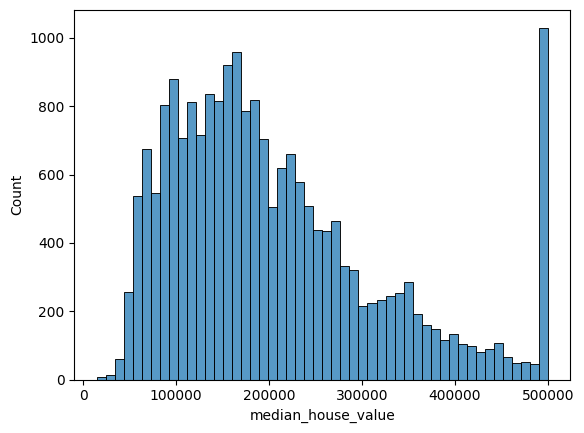

In [5]:
sns.histplot(df["median_house_value"], bins=50)

It looks like the distribution has a heavy right skew. The large number of values at 500,000 is likely a matter of coding, where anything >$500,000 was just coded as 500,000.

Let's remove these from our dataset as we don't want those arbitrarily coded values to affect our dataset (plus, 500,000 isn't actually what they were sold for, so if we keep them then we're doing a classification problem instead of a regression problem).

We also generally dislike skew in our output variables. Although we don't explicitly need a normal distribution for our output variable, linear regression does assume that the residuals are normally distributed (see [here](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/normality/) for an explanation). If our outcome variable $$Y$$ is too skewed, then it becomes more unlikely that our residuals are normally distributed, and for our residuals to be closer to normally distributed our regression outline would have to be pulled in the direction of our skew, which increases the errors on the majority of our distribution.

To resolve this, we can do a log transformation of our output variable (see [here](https://onlinestatbook.com/2/transformations/log.html) for an explanation). The log transform reduces skewness and brings values closer to the center of the distribution. We can do this using `np.log1p` (we use the `1p` since we can't take a log of a zero, so using 1p prevents that problem). We will use this transformed variable as our output $$Y$$ and then exponentiate it (using `np.exp1m`) to get our predictions.

*Note: the more transformations that we do on our dataset, the less interpretable our results are going to be (even though it is a linear regression). We need to keep this in mind when making our modeling choices - do we want to prioritize performance at the cost of simplicity and explainability. Notably, a linear regression is probably the most explainable ML algorithm, but as we have the option to choose other ML algorithms we need to also consider this explainability vs. black box tradeoff as well.*

So, in short, we will:
1. Remove all the rows whose `median_house_value` was coded as the maximum value of 500,000 (we might lose some homes that actually were 500,000, but the vast majority are homes that were priced at >500,000) (note: if we wanted to account for the homes that were >500,000, we could build a second model, a classification model, that determines if a home was sold for =<500,000 or >500,000).
2. Perform a log transformation on the y-values in order to reduce skew.


In [6]:
max_house_value = df["median_house_value"].max()

In [7]:
num_max_coded_rows = len(
    [
        val for val in df["median_house_value"].values
        if val == max_house_value
    ]
)

In [8]:
print(f"Number of rows with max value that we will be removing: {num_max_coded_rows}")
print(f"Dataframe length before filtering: {len(df)}")

Number of rows with max value that we will be removing: 965
Dataframe length before filtering: 20640


In [9]:
# exclude all rows where median_house_value is equal to the max value
df = df[df["median_house_value"] != max_house_value]

In [10]:
print(f"Dataframe length after filtering: {len(df)}")

Dataframe length after filtering: 19675


Let's take a look at the distribution after removing the 500,000+ values:

<Axes: xlabel='median_house_value', ylabel='Count'>

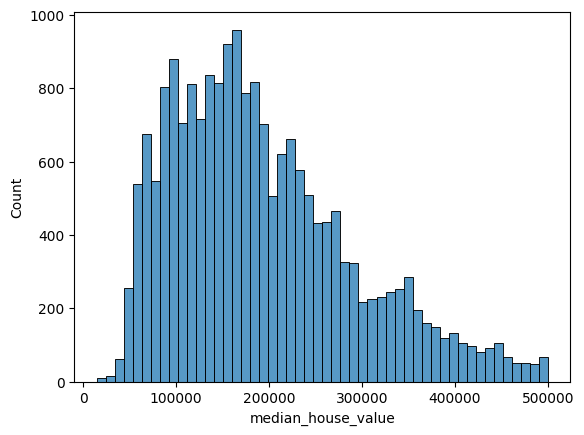

In [11]:
sns.histplot(df["median_house_value"], bins=50)

Now the spike in the values after 500,000 is gone, but there is still a right skew. Let's log-transform the y-values in order to fix this.

In [12]:
median_housing_values = df["median_house_value"]
y = np.log1p(df["median_house_value"])

<Axes: xlabel='median_house_value', ylabel='Count'>

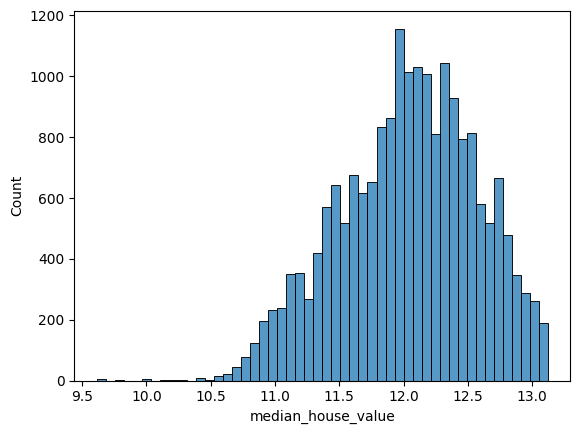

In [13]:
sns.histplot(y, bins=50)

This still has some skew, but it is a big improvement over our previous output variable. The lower the skewness of the underlying distribution, the more likely it is that the residuals will actually follow a normal distribution, which is a fundamental assumption of regression.

In [14]:
del df["median_house_value"]

For our problem, let's take a look at only the properties that are not right on the water, but are some distance away. Since this is a linear regression problem, let's also just look at the columns that are numeric and might have some relationship with the median home price.

In [15]:
property_types = ["<1H OCEAN", "INLAND"]
X = df[df['ocean_proximity'].isin(property_types)]
y = y[y.index.isin(X.index)]
columns = [
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households", 
    "median_income"
]

X = X[columns]

Let's take a look at our dataset now and see what we can learn:

In [16]:
X.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
701,32.0,1283.0,194.0,485.0,171.0,6.0574
830,9.0,3666.0,711.0,2341.0,703.0,4.6458
859,21.0,4342.0,783.0,2172.0,789.0,4.6146
860,15.0,3575.0,597.0,1777.0,559.0,5.7192
861,20.0,4126.0,1031.0,2079.0,975.0,3.6832


When doing exploratory data analysis, some of the things that we want to look for include:

1. Outliers: do we have outliers in our data that we should account for?
2. Missing data: do we have any data that is missing? If so, can we impute the missing data?
3. Correlations: are any of the features correlated to each other? If so, can we eliminate redundant features?

Let's do these in steps.

*Note: we do NOT need to scale data when it comes to linear regression. This is because each parameter estimate is scaled to each feature already. For regression, we would only scale if we want our intercepts to be centered at 0 for interpretability purposes, but that doesn't apply in this case. We need to scale if we're working with algorithms that use distance metrics of some sort, such as clustering algorithms or gradient descent in neural networks (see [here](https://www.atoti.io/articles/when-to-perform-a-feature-scaling/) for more information)*

#### Outliers

We want to check for the presence of outliers. Since regression minimizes the average squared error, an outlier will pull the regression line towards itself and away from other values so that the average squared error is minimized. Therefore, we should check for outliers and handle them accordingly (perhaps, for example, by filtering them, or by doing something like a log transformation).

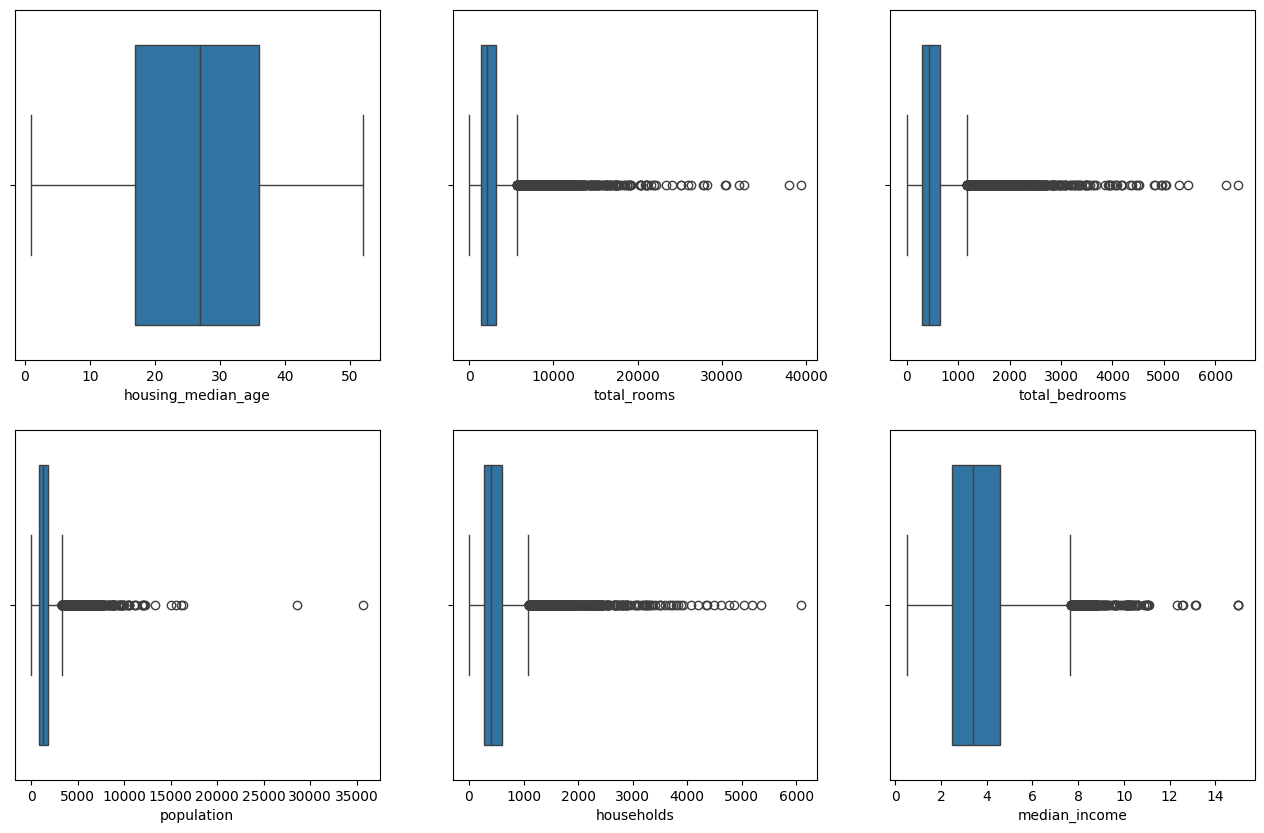

In [17]:
# boxplots for each feature
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(x=col, data=X, ax=axes[i])

For some of these features, there are clearly some outlier values. We may benefit from doing a log transform of the values since there are so many outliers that we can't filter them. Another approach that may be more robust is to separate the rows that do not have outlier values from those that do, and do a linear regression solely on the rows that do not have outlier values and then do a separate model for those that do have outlier values.

For the present, though, let's keep these values as is.

#### Missing data

We want to check if there is any data that is missing in our dataset. We can look for the presence of NaN values and similar values such as null or None. We also have to be careful for the presence of other values that can signify missing data. For example, when working with survey data sometimes a field is coded as -999 if there is no valid answer. Sometimes we might even see empty strings, "", used to denote missing data. In this case, given our feature set, looking for NaN values should suffice, especially since the fields that we're looking at are already all converted to numerics (meaning that any non-numeric value is encoded as NaN).

In [18]:
fields_with_missing_data = []

for field in X.columns:
    missing_data = X[field].isnull().sum()
    if missing_data > 0:
        fields_with_missing_data.append(field)
        print(f"{field} has {missing_data} missing values")

total_bedrooms has 154 missing values


We see that `total_bedrooms` has some missing values whereas the rest of the data does not have any missing values. We may want to somehow impute values for the missing values in `total_bedrooms`, but let's first determine if this is a feature that we want to keep in the first place, which we can find out if we look at the feature correlations.

#### Correlations

We want features that are generally not really correlated with each other. Conceptually, this is because we want each feature used in our prediction to add more information that will help us make a better prediction.

*Note: mathematically, we need features that aren't correlated - the problem of correlated features, also known as multicollinearity, makes the linear regression problem more difficult, see [here](https://markptorres.com/machine_learning/notes-linear-regression) for more information*

Let's take a look at the correlations between our features:

Let's take a look at the correlations of our features

<Axes: >

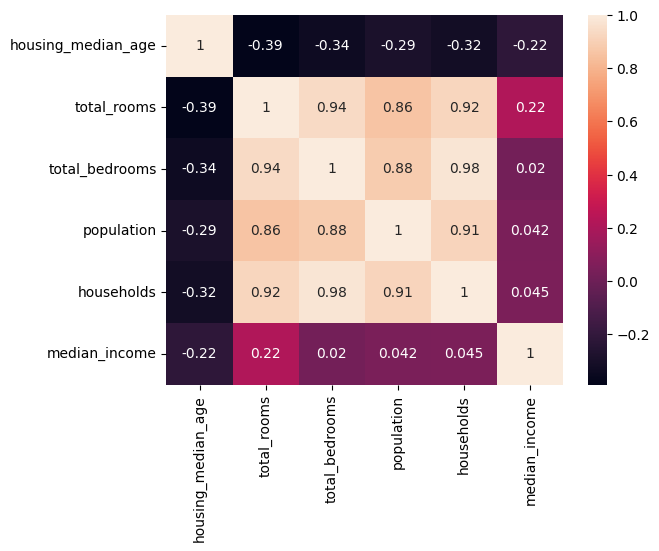

In [19]:
sns.heatmap(X.corr(), annot=True)

As we can see here, the `total_rooms`, `total_bedrooms`, `population`, and `households` are really highly correlated with each other. If we think about it, this makes sense - the larger the population, the more households there are. The more households there are, the more total bedrooms there are, and the more total bedrooms there are, the more total rooms there are.

Because of this, we can choose to just keep one of the variables. Since our purpose is to predict house prices, it makes logical sense that the price of a house is likely highly related to how large the house is, which is a factor of the total rooms in the house (of which bedrooms is a part), which leaves us with `total_rooms` and `total_bedrooms`. Since these two are highly correlated (and logically so), we should pick only one. Since we found that `total_bedrooms` has some rows with missing values, let's use `total_rooms` instead.

#### Picking a subset of features and mapping them against our output variable

After exploring our features, we now have a sense of which features we should include in our model. We want to pick features that are not correlated with each other, so that each can help us predict the home price. Let's choose the `housing_median_age`, `median_income`, and `total_rooms` variables. Now let's check how these each relate to our log-transformed output variable, `housing_median_price`.

In [20]:
cols = ["housing_median_age", "median_income", "total_rooms"]
X = X[cols]

In [21]:
data = X.copy()
data["median_house_value"] = y.values

<Axes: >

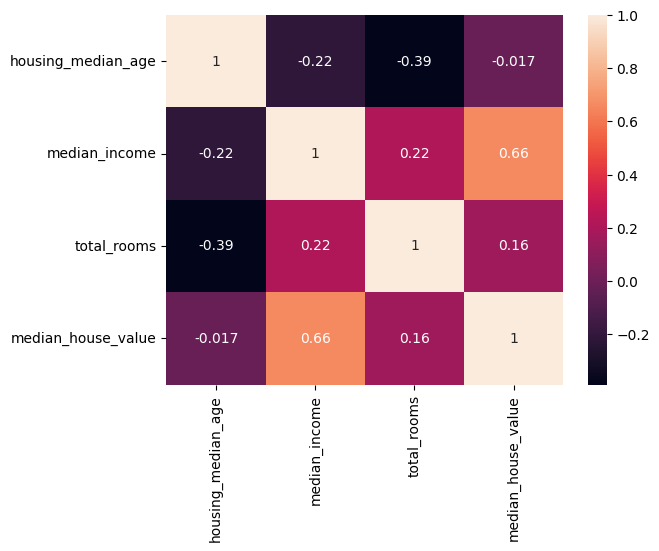

In [22]:
# show the correlation matrix between each column in X and the values in y
sns.heatmap(data.corr(), annot=True)

From the looks of it, `median_income` is the most correlated to `median_house_price`. Logically this makes sense - the higher a community's income, the more expensive the homes in the community likely are. We also see that `housing_median_age` is not correlated with `median_housing_price`, which also makes sense - it's not the age of the homebuyer that matters but rather the features of the home itself (like the `total_rooms`, which has some slight correlation).

Let's also create scatterplots of each feature against the output variable just to see how they look. We'll plot the features against their original prices, since this will look cleaner from a visualization perspective and there will be less cluttering as opposed to the log-transformed version of the prices:

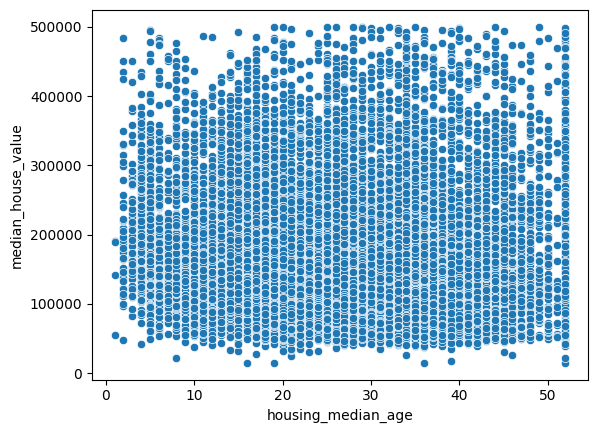

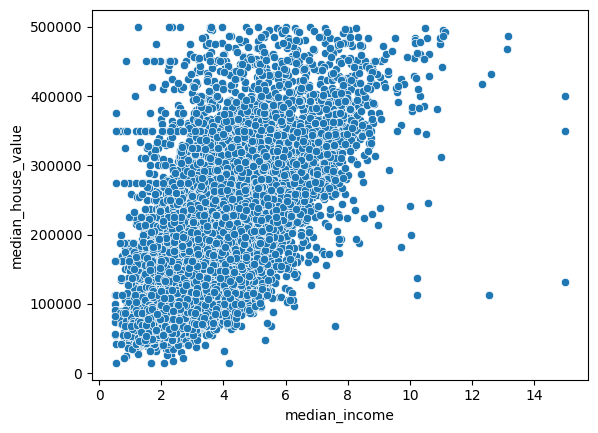

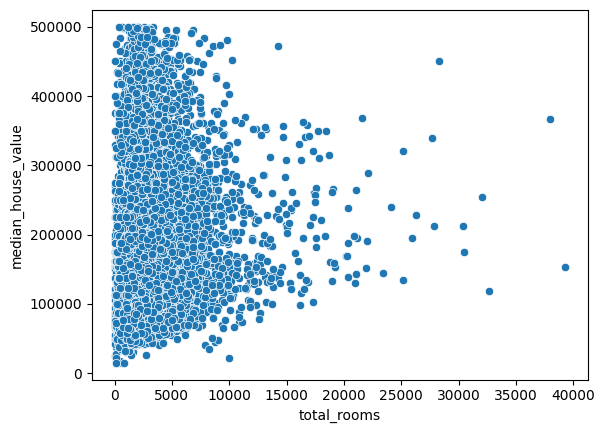

In [23]:
for col in X.columns:
    sns.scatterplot(x=X[col], y=np.expm1(y))
    plt.show()

The scatterplots reinforce what we already observed from the correlation matrix and give us some indication of how each feature variable relates to the median home price. We can later superimpose the coefficients created by our regression model against these scatterplots to see how well the coefficients for each parameter reflect the underlying data.

Now that we've done these exercises, we now know (1) which features we want to use and (2) how these features relate to our output variable, `median_house_price`. This means that we are now ready to actually perform the regression.

## Perform regression

In this overview, we'll skip over [what is a linear regression](https://www.ibm.com/topics/linear-regression), [how to solve the linear regression equation](https://markptorres.com/machine_learning/notes-linear-regression) as well as [why linear regression minimizes squared error](https://markptorres.com/machine_learning/notes-least-squares-regression) and we'll instead focus on implementation. To perform our regression, we need to do the following:

1. Split up our data into training, validation, and test sets.
2. Create regression model.
3. Evaluate our model's performance.

*Note: we are sticking to a linear regression for this walkthrough. We will not explore techniques such as regularization or dimensionality reduction. We also will not be doing cross-validation, though [this Kaggle tutorial](https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression) has a great walkthrough of doing cross validation with linear regression*

### Splitting our data into training, validation, and test sets

We want to split up our data into training, validation, and test sets. 
- Training: this is the data that our model receives and is trained on.
- Validation: this is the data that we use to evaluate our model's performance and to tune our model. We use this to see how well our current iteration of the model is doing and compare that to other versions of our model. This comes in handy, for example, if we're tuning our hyperparameters, changing algorithm type, etc.
- Test: this is a set of data that we use to evaluate our final model. This is never used during the model creation and iteration process and is only used at the end to actually see how the model performs.

As a simple heuristic, we can split our data into 70% for training, 20% for validation, and 10% for testing.

In [24]:
prop_training = 0.7
prop_validation = 0.2
prop_test = 0.1

num_rows = len(X)
num_validation_rows = int(num_rows * prop_validation)
num_test_rows = int(num_rows * prop_test)
num_training_rows = num_rows - num_validation_rows - num_test_rows

print(f"Total number of rows: {num_rows}")
print(f"Number of training rows: {num_training_rows}")
print(f"Number of validation rows: {num_validation_rows}")
print(f"Number of test rows: {num_test_rows}")

Total number of rows: 15128
Number of training rows: 10591
Number of validation rows: 3025
Number of test rows: 1512


In [25]:
# reset the indices of our data
data = data.reset_index(drop=True)

In [26]:
X_cols = ["housing_median_age", "median_income", "total_rooms"]
y_col = ["median_house_value"]

X = data[X_cols]
y = data[y_col]

In [27]:
# shuffle the indices of our data
all_indices = data.index.values
np.random.shuffle(all_indices)

# get the indices for the training, validation, and test sets
training_indices = all_indices[:num_training_rows]
validation_indices = all_indices[num_training_rows:num_training_rows+num_validation_rows]
test_indices = all_indices[num_training_rows+num_validation_rows:]

# subset our data into training, validation, and test sets
X_train = X[X.index.isin(training_indices)]
X_validation = X[X.index.isin(validation_indices)]
X_test = X[X.index.isin(test_indices)]

y_train = y[y.index.isin(training_indices)]
y_validation = y[y.index.isin(validation_indices)]
y_test = y[y.index.isin(test_indices)]

In [28]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_validation)}")
print(f"Test set size: {len(X_test)}")

Training set size: 10591
Validation set size: 3025
Test set size: 1512


We now have successfully split up our data into training, validation, and test sets.

### Creating a regression model

Now that our data is prepared for the model, we can create our regression model.

In [29]:
# fit our regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# Make predictions on the validation set
y_pred = model.predict(X_validation)

### Evaluating our model's performance

Now that we have a fitted model and have predictions on our validation set, let's evaluate the performance.

#### Spot-check one example

Let's look at one of the examples and see how our model did.

In [31]:
example_index = 10
example_X = X_validation.iloc[example_index]
example_y = y_validation.iloc[example_index]
example_y_pred = y_pred[example_index]

In [32]:
example_housing_median_age = example_X["housing_median_age"]
example_median_income = example_X["median_income"]
example_total_rooms = example_X["total_rooms"]

In [33]:
example_y_price = np.expm1(example_y)
example_y_pred_price = np.expm1(example_y_pred)

In [34]:
print(f"Housing median age: {example_housing_median_age}")
print(f"Median income: {example_median_income}")
print(f"Total rooms: {example_total_rooms}")
print(f"Actual median house value: {int(example_y_price.values[0])}")
print(f"Predicted median house value: {int(example_y_pred_price[0])}")

Housing median age: 40.0
Median income: 3.0912
Total rooms: 2352.0
Actual median house value: 155299
Predicted median house value: 157627


Our model predicted that the median house value would be $157,627, and in reality the actual median house value was $155,299. Looks pretty close to me!

#### Evaluating error metrics

In [35]:
# Evaluate the model using metrics
mse = mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

In [36]:
print(f"Mean squared error: {mse}")
print(f"R2 score: {r2}")

Mean squared error: 0.13554384791905416
R2 score: 0.4960874690210101


We see that our model has a mean squared error (MSE) value of 0.13. This means that the average squared difference between our predictions and the true value is 0.13. We see that the R^{2} value is 0.49, meaning that 49% of the variance in the median home prices is accounted for by our model.

How do we interpret these statistics? That's outside the scope of this walkthrough, but see the [MSE explanation](https://statisticsbyjim.com/regression/mean-squared-error-mse/) and [R-squared explanation](https://statisticsbyjim.com/regression/interpret-r-squared-regression/) provided here.

#### How do we know if our model is good?

We have the metrics above, the MSE and the R^{2} values, which tell us how "good" the model is, but pragmatically this doesn't tell us much information. After all, is an R^{2} value of 0.49 good? Is an MSE of 0.13 good? To find out, let's plot our predicted median home prices against our actual home prices:

In [37]:
y_validation_true_prices = np.expm1(y_validation)
y_pred_true_prices = np.expm1(y_pred)

Let's check out the distribution of both the true prices and the predicted prices

<Axes: ylabel='Count'>

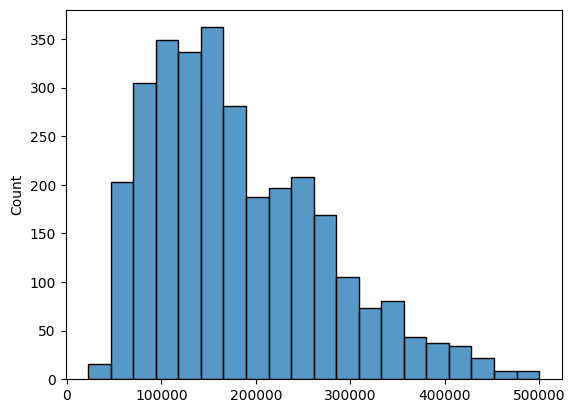

In [38]:
# true prices
sns.histplot(y_validation_true_prices.values[:,0], bins=20)

<Axes: ylabel='Count'>

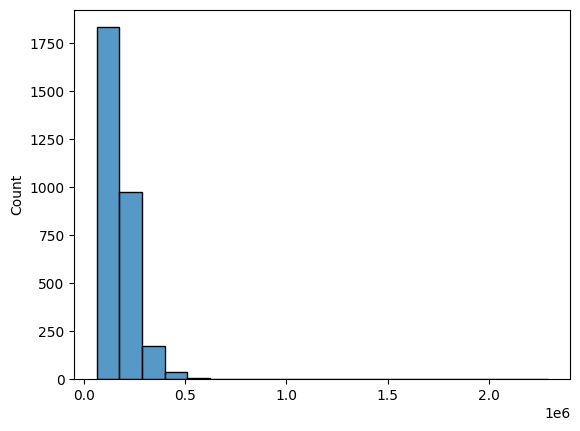

In [39]:
# predicted prices
sns.histplot(y_pred_true_prices[:,0], bins=20)

<Axes: >

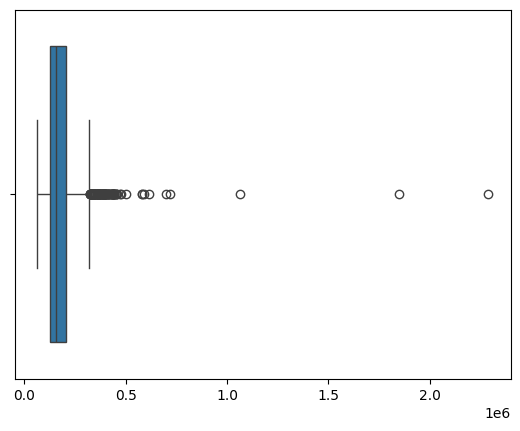

In [40]:
# boxplot of predicted prices
sns.boxplot(x=y_pred_true_prices[:,0])

<Axes: >

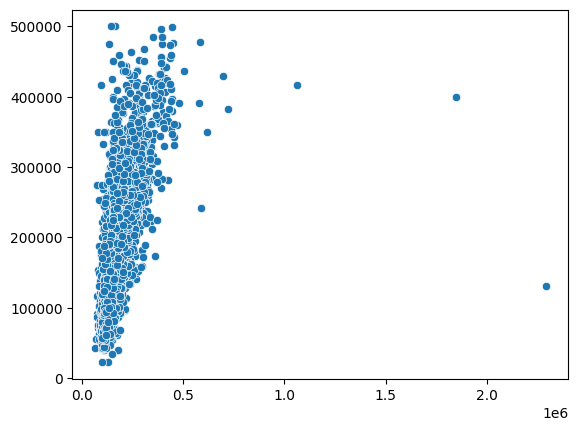

In [41]:
# plot against each other
sns.scatterplot(x=y_pred_true_prices[:,0], y=y_validation_true_prices.values[:,0])

As we can see, our model does OK at predicting prices that are lower in value, but it does a poor job overall at predicting our prices. Our model only really predicts prices for home <$100,000, and even then it is not the best at doing so. Our R-squared happens to be as high as it is likely because most of the homes fall within this range. Our model consistently underestimates the prices of homes once their price is greater than $100,000.

Clearly our model can be improved. It's likely that we will see dramatic gains if we were to include more features into our model. We only included, for the purposes of this walkthrough, the continuous features and not the categorical ones.

## Checking the assumptions of linear regression

Now that we have a working model, we need to check to see if our model does fit the assumptions of linear regression.

The assumptions of linear regression are:

1. Independence of the observations: is each observation independent of the other?
2. The true relationship between the features and the output variable is linear.
3. Errors are normally distributed.
4. Homoscedasticity: the variance of the residuals is constant regardless of the actual prediction.

We know that (1) is true, since each row is a distinct area's home details (this assumption can fail, for example, in time series data). We assume that (2) is true, otherwise we wouldn't do a linear regression (we get further evidence by looking at the scatterplots and seeing that even if a straight line isn't really a great fit, it is a better fit than any polynomial alternatives). So, we just need to check for assumptions (3) and (4).

In [42]:
residuals = y_validation_true_prices.values[:,0] - y_pred_true_prices[:,0]

### Errors are normally distributed

We want to look at the distribution of the errors and see if they are normally distributed. If not, then this is a possible indication of errors in the underlying approach (e.g., skew in the data, a linear model wasn't appropriate, etc.).

<Axes: ylabel='Count'>

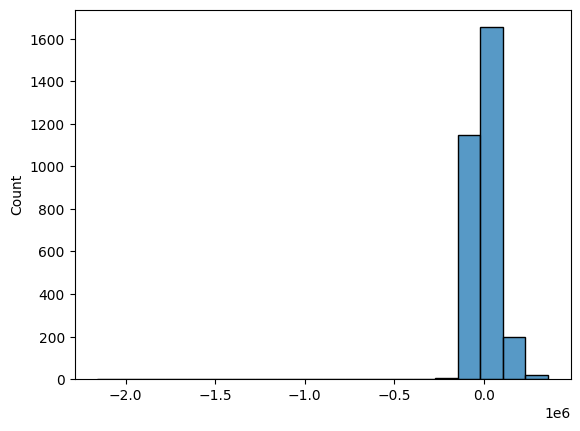

In [43]:
sns.histplot(residuals, bins=20)

Though there is a large left skew, we know that the model is imperfect and the left skew is likely accounting for the cases where the model severely underestimates the actual home price (i.e., the model consistently returns prices in the ~$100,000 range even for homes that are $300,000+). We've discussed this limitation already and know how to address it, so this plot doesn't tell us information that we don't already know. Otherwise, it appears that the errors do have a normal distribution, so our result is OK.

We can also formalize this using the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) for residuals.

In [44]:
from scipy import stats

shapiro_test_stat, shapiro_p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test - Statistic: {shapiro_test_stat}, p-value: {shapiro_p_value}")

if shapiro_p_value > 0.05:
    print("Residuals appear to be normally distributed (p-value > 0.05)")
else:
    print("Residuals do not appear to be normally distributed (p-value <= 0.05)")


Shapiro-Wilk Test - Statistic: 0.6770879626274109, p-value: 0.0
Residuals do not appear to be normally distributed (p-value <= 0.05)


This tells us that our errors are not normally distributed, but again this is likely due to the caveats mentioned above.

### Homoscedasticity

To check for homoscedasticity, we can plot the residuals against the predicted values. Ideally what we want to see is that regardless of the actual value that we predicted, our residual is randomly distributed. We don't want to see, for example, our errors being larger as we predict greater values.

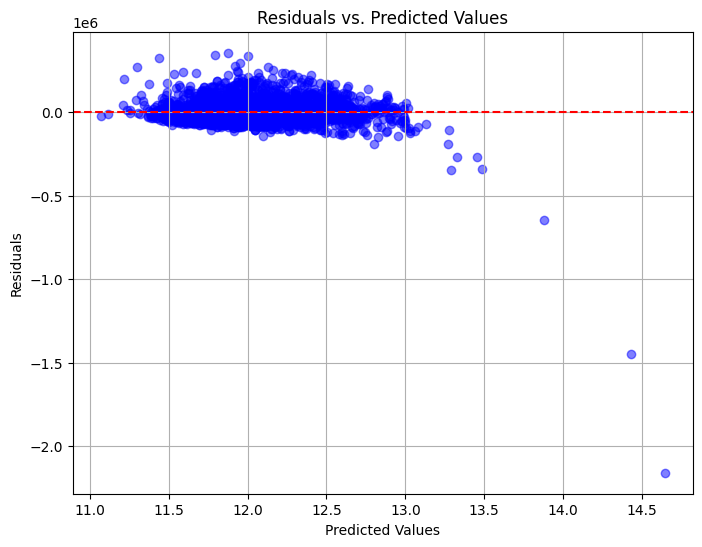

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In this case, we see that for the majority of our dataset, the homoscedasticity assumption is met. We see errors greatly increasing for higher values of predicted values though, which violates the homoscedasticity requirement. However, this is likely due to the same limitations mentioned previously.

## Conclusion

This was a brief walkthrough on how to apply linear regression in Python. We used a dummy dataset of house prices and did exploratory data analysis, fitted a regression model, and analyzed the results.